In [1]:
!pip install --user --upgrade pip
!pip install PyWavelets

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable


In [9]:
import sys

lib_path = '/work-hmcomm/project/nedo2020_yokogawa/Git/yokogawa_knikaido/fastd-learning/src'
sys.path.insert(0, lib_path)

import numpy as np
import numpy # Since some code's been cut and pasted from elsewhere we need this too 
import os
import matplotlib.pyplot as plt
import glob
import pickle
import scipy.fftpack as spfft
from scipy import signal
import librosa
import librosa.display
from tqdm import tqdm
import pywt
import cwt
import pandas as pd

from util.util import parse_audio_from_wav
from feature.feature_mfcc import FeatureMfcc

In [3]:
fs = 96000

In [4]:
wav_list = sorted(glob.glob('/work-hmcomm/project/nedo2020_yokogawa/data/PilotPlant_Experiments_2020-0309/wav_mixing/anom_oneshot/*_5_*Exp02*anom09*left*-15*.wav'))
# wav_list.extend(sorted(glob.glob('/work-hmcomm/project/nedo2020_yokogawa/data/PilotPlant_Experiments_2020-0309/wav_mixing/anom_oneshot/*_5_*Exp02*anom09*left*-20*.wav')))
# wav_list.extend(sorted(glob.glob('/work-hmcomm/project/nedo2020_yokogawa/data/PilotPlant_Experiments_2020-0309/wav_mixing/anom_oneshot/*_5_*Exp02*anom09*left*-25*.wav')))

# wav_list.pop(5)
# wav_list=wav_list[0]
wav_list = wav_list[:10]
len(wav_list)

10

In [5]:
widths = 2 ** (np.arange(1, 65) / 4) 
widths

array([1.18920712e+00, 1.41421356e+00, 1.68179283e+00, 2.00000000e+00,
       2.37841423e+00, 2.82842712e+00, 3.36358566e+00, 4.00000000e+00,
       4.75682846e+00, 5.65685425e+00, 6.72717132e+00, 8.00000000e+00,
       9.51365692e+00, 1.13137085e+01, 1.34543426e+01, 1.60000000e+01,
       1.90273138e+01, 2.26274170e+01, 2.69086853e+01, 3.20000000e+01,
       3.80546277e+01, 4.52548340e+01, 5.38173706e+01, 6.40000000e+01,
       7.61092554e+01, 9.05096680e+01, 1.07634741e+02, 1.28000000e+02,
       1.52218511e+02, 1.81019336e+02, 2.15269482e+02, 2.56000000e+02,
       3.04437021e+02, 3.62038672e+02, 4.30538965e+02, 5.12000000e+02,
       6.08874043e+02, 7.24077344e+02, 8.61077929e+02, 1.02400000e+03,
       1.21774809e+03, 1.44815469e+03, 1.72215586e+03, 2.04800000e+03,
       2.43549617e+03, 2.89630938e+03, 3.44431172e+03, 4.09600000e+03,
       4.87099234e+03, 5.79261875e+03, 6.88862343e+03, 8.19200000e+03,
       9.74198469e+03, 1.15852375e+04, 1.37772469e+04, 1.63840000e+04,
      

In [6]:
widths = np.exp(np.arange(1, 7, 0.1))
widths

array([  2.71828183,   3.00416602,   3.32011692,   3.66929667,
         4.05519997,   4.48168907,   4.95303242,   5.47394739,
         6.04964746,   6.68589444,   7.3890561 ,   8.16616991,
         9.0250135 ,   9.97418245,  11.02317638,  12.18249396,
        13.46373804,  14.87973172,  16.44464677,  18.17414537,
        20.08553692,  22.19795128,  24.5325302 ,  27.11263892,
        29.96410005,  33.11545196,  36.59823444,  40.44730436,
        44.70118449,  49.40244911,  54.59815003,  60.3402876 ,
        66.68633104,  73.6997937 ,  81.45086866,  90.0171313 ,
        99.48431564, 109.94717245, 121.51041752, 134.28977968,
       148.4131591 , 164.0219073 , 181.27224188, 200.33680997,
       221.4064162 , 244.69193226, 270.42640743, 298.86740097,
       330.29955991, 365.03746787, 403.42879349, 445.85777008,
       492.74904109, 544.57191013, 601.84503787, 665.14163304,
       735.09518924, 812.40582517, 897.84729165, 992.27471561])

# Scalo

### Tominagasan

CPU times: user 2.16 s, sys: 252 ms, total: 2.41 s
Wall time: 2.13 s


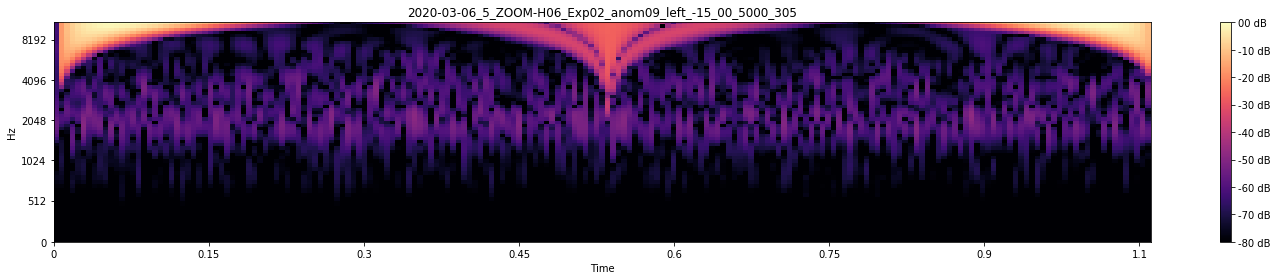

In [15]:
%%time
start = 0
Fs = fs
step = int(96000*0.05)


# widths = np.exp(np.arange(1, 7, 0.1))
widths = 2 ** (np.arange(1, 64) / 4)

for i in range(len(wav_list)):
    
    cwt_ave_sum = []
    wavpath = wav_list[i]
    _, a =   parse_audio_from_wav(wavpath,sample_rate=fs)
#     wavdata = a[:,1]
    wavdata = a.reshape(-1)

    cwtmatr = cwt.step_cwt(np.abs(wavdata), cwt.ricker, widths, step=step)
#     log_cwtmatr = np.log(cwtmatr)
    log_cwtmatr = librosa.amplitude_to_db(cwtmatr, ref=np.max)
    
    
#  
#     print('**********'+wavpath+'**********')
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(log_cwtmatr, sr=fs, x_axis='time', y_axis='mel')
    plt.title(wavpath[101:-4])
    plt.colorbar(format='%02.0f dB')
    plt.tight_layout()

#     fig.colorbar(img, cax=ax3)
    #     savename = savepath + wavpath[101:-4] + '_scalogram_S200W400.npy' 
#     np.save(savename, cwtmatr)
    break

### PyWavelet

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


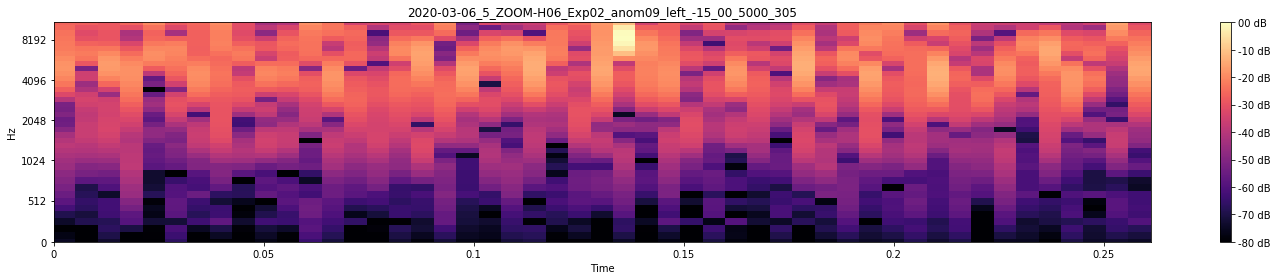

In [10]:
start = 0
Fs = fs

widths = np.exp(np.arange(1, 7, 0.1))

for i in range(len(wav_list)):
    
    cwt_ave_sum = []
    wavpath = wav_list[i]
    _, a =   parse_audio_from_wav(wavpath,sample_rate=fs)
#     wavdata = a[:,1]
    wavdata = a.reshape(-1)
    
    for j in tqdm(np.arange(1, 7)):

        if(j<=5):
            widths = np.exp(np.arange(j, j+1, 0.10))
        else:
            widths = np.exp(np.arange(j, j+1, 0.10))

        cwtmatr, freqs = pywt.cwt(wavdata, widths, 'morl', sampling_period=1/Fs, method='fft')
        # cwtmatr += np.abs(np.min(cwtmatr))
        np.set_printoptions(suppress=True)

        win_length=0.04*fs
        hop_length=0.02*fs
        start = 0
        cwtmatr = np.abs(cwtmatr)
        cwt_ave = []

        num_signal = int((len(cwtmatr[0]) - win_length) / hop_length) + 1
        for i in range(num_signal):

            con_cwt = cwtmatr[:,int(start):int(start+win_length)]
            cwt_ave.append(np.log(np.array(np.average(con_cwt ,axis=1))))
            
            start += hop_length

#         cwt_ave = np.array(cwt_ave).T
        cwt_ave_sum.extend(np.array(cwt_ave).T)
    
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(log_cwtmatr, sr=fs, x_axis='time', y_axis='mel')
    plt.title(wavpath[101:-4])
    plt.colorbar(format='%02.0f dB')
    plt.tight_layout()
    break

In [87]:
cwtmatr

array([[ 1.70008635e+07,  3.44700723e+06,  1.91653620e+07, ...,
        -4.08775861e+07,  6.21418362e+06, -4.17510695e+07],
       [ 1.34803118e+07,  6.11517829e+06,  2.77945161e+07, ...,
        -6.15370171e+07,  3.04005254e+06, -5.89107130e+07],
       [ 5.95546321e+06,  1.17438896e+07,  3.94572382e+07, ...,
        -8.95627658e+07, -5.85408073e+06, -8.04871605e+07],
       ...,
       [-4.55679165e+09,  7.47821389e+11,  1.48488197e+12, ...,
         2.86122908e+12,  2.19898568e+12,  1.49250454e+12],
       [-4.40079546e+09,  7.48717142e+11,  1.49097664e+12, ...,
         2.90749446e+12,  2.21887242e+12,  1.49845899e+12],
       [-4.50741855e+09,  7.49122787e+11,  1.49505884e+12, ...,
         2.94062010e+12,  2.23299240e+12,  1.50263071e+12]])

# Mel

In [82]:
S = librosa.feature.melspectrogram(wavdata.astype('float32'), sr=fs, n_fft=step*2, hop_length=step, n_mels=128)
# log_S = librosa.amplitude_to_db(S, ref=np.max)
log_S = np.log(S)
plt.figure(figsize=(20, 4))
librosa.display.specshow(log_S, sr=fs, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()

IndexError: cannot do a non-empty take from an empty axes.

<Figure size 1440x288 with 0 Axes>

In [83]:
S

array([[1.6932590e+21, 1.7533173e+21, 1.7566852e+21, ..., 1.7915347e+21,
        1.6736885e+21, 1.7564465e+21],
       [3.3990657e+19, 2.5601141e+19, 3.2406300e+19, ..., 1.9369274e+19,
        6.9159336e+18, 3.4746536e+18],
       [1.2842842e+20, 5.0547703e+19, 3.7824519e+19, ..., 3.1584096e+19,
        1.8373406e+19, 7.0924429e+19],
       ...,
       [8.4706503e+13, 6.5613519e+13, 8.2781351e+13, ..., 7.9016007e+13,
        7.1460698e+13, 7.4285738e+13],
       [7.3838130e+13, 7.4354893e+13, 8.2040905e+13, ..., 7.2820852e+13,
        6.9392826e+13, 8.7030835e+13],
       [8.4393306e+13, 7.8597876e+13, 7.1871597e+13, ..., 7.0037696e+13,
        7.3580113e+13, 9.2717774e+13]], dtype=float32)

In [36]:
np.log(S)

array([[46.433956, 46.796104, 46.65765 , ..., 46.81973 , 46.782887,
        46.709724],
       [45.930954, 46.215546, 46.1057  , ..., 46.2312  , 46.209236,
        46.126827],
       [44.350456, 42.37693 , 43.711067, ..., 39.88889 , 42.952847,
        41.97541 ],
       ...,
       [28.804163, 29.484737, 29.299698, ..., 29.324211, 29.012003,
        29.126883],
       [29.137611, 29.173233, 29.338438, ..., 29.21885 , 29.165714,
        29.423536],
       [29.18366 , 29.52036 , 29.045744, ..., 29.224482, 29.33659 ,
        29.518398]], dtype=float32)